In [15]:
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
from tqdm.autonotebook import tqdm

from xhistogram.xarray import histogram
import cartopy.crs as ccrs
import cartopy
import matplotlib.ticker as mticker
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'

In [2]:
#df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,BCC,BCC-ESM1,piClim-CH4,r1i1p1f1,Amon,ch4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-CH4/...,NaN
1,AerChemMIP,BCC,BCC-ESM1,piClim-CH4,r1i1p1f1,Amon,clt,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-CH4/...,NaN
2,AerChemMIP,BCC,BCC-ESM1,piClim-CH4,r1i1p1f1,Amon,co2,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-CH4/...,NaN
3,AerChemMIP,BCC,BCC-ESM1,piClim-CH4,r1i1p1f1,Amon,evspsbl,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-CH4/...,NaN
4,AerChemMIP,BCC,BCC-ESM1,piClim-CH4,r1i1p1f1,Amon,hfls,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-CH4/...,NaN


In [3]:
#df_3hr_pr = df[(df.table_id == '3hr') & (df.variable_id == 'pr')]
df_Omon_uo = df[(df.table_id == 'Omon') & (df.variable_id == 'uo') & (df.source_id == 'GFDL-CM4')]#& (df.activity_id == 'CMIP')]
len(df_Omon_uo)

4

In [4]:
#df_3hr_pr.head()
df_Omon_uo.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
45163,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Omon,uo,gn,gs://cmip6/CMIP/NOAA-GFDL/GFDL-CM4/historical/...,NaN
45312,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Omon,uo,gn,gs://cmip6/CMIP/NOAA-GFDL/GFDL-CM4/piControl/r...,NaN
232834,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp245,r1i1p1f1,Omon,uo,gn,gs://cmip6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp2...,NaN
232970,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,Omon,uo,gn,gs://cmip6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp5...,NaN


In [5]:
#df_3hr_pr.groupby(['experiment_id', 'source_id'])['zstore'].count()
df_Omon_uo.groupby(['experiment_id', 'source_id'])['zstore'].count()

experiment_id  source_id
historical     GFDL-CM4     1
piControl      GFDL-CM4     1
ssp245         GFDL-CM4     1
ssp585         GFDL-CM4     1
Name: zstore, dtype: int64

In [6]:
run_counts = df_Omon_uo.groupby(['source_id', 'experiment_id'])['zstore'].count()
run_counts

source_id  experiment_id
GFDL-CM4   historical       1
           piControl        1
           ssp245           1
           ssp585           1
Name: zstore, dtype: int64

In [7]:
source_ids = []
experiment_ids = ['piControl']
#for name, group in df_3hr_pr.groupby('source_id'):
for name, group in df_Omon_uo.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        source_ids.append(name)
source_ids

['GFDL-CM4']

In [8]:
def load_pr_data(source_id, expt_id):
    """
    Load 3hr precip data for given source and expt ids
    """
 #   uri = df_3hr_pr[(df_3hr_pr.source_id == source_id) &
 #                        (df_3hr_pr.experiment_id == expt_id)].zstore.values[0]
    uri = df_Omon_uo[(df_Omon_uo.source_id == source_id) &
                         (df_Omon_uo.experiment_id == expt_id)].zstore.values[0]
   
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [9]:
source_ids

['GFDL-CM4']

In [10]:
results = {}
for source_id in tqdm(source_ids):
    ds = load_pr_data(source_id, 'piControl')


In [11]:
ds.lev[27:]

<xarray.DataArray 'lev' (lev: 8)>
array([3000., 3500., 4000., 4500., 5000., 5500., 6000., 6500.])
Coordinates:
  * lev      (lev) float64 3e+03 3.5e+03 4e+03 4.5e+03 ... 5.5e+03 6e+03 6.5e+03
Attributes:
    axis:         Z
    bounds:       lev_bnds
    description:  generic ocean model vertical coordinate (nondimensional or ...
    long_name:    ocean model level
    positive:     down
    units:        m

In [12]:
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lev: 35, time: 6000, x: 1440, y: 1080)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    lat        (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(35, 2), meta=np.ndarray>
    lon        (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
  * time       (time) object 0151-01-16 12:00:00 ... 0650-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
  * x          (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * y          (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Data variables:
    uo         (time, lev, y, x) float32 dask.array<chunksize=(1, 35, 1080, 1440), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  54750.0
    comment:                <null ref>
    contact:                gfdl.climate.model.info@noaa.gov
    creation_date:          2019-02-07T21:16:00Z
    data_specs_version:     01.00.27
    experiment:             pre-industrial control
    experiment_id:          piControl
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NOAA-GFDL.GF...
    grid:                   ocean data on native grid tripolar - nominal 0.25...
    grid_label:             gn
    history:                File was processed by fremetar (GFDL analog of CM...
    initialization_index:   1
    institution:            National Oceanic and Atmospheric Administration, ...
    institution_id:         NOAA-GFDL
    license:                CMIP6 model data produced by NOAA-GFDL is license...
    mip_era:                CMIP6
    nominal_resolution:     25 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl-spinup
    parent_mip_era:         CMIP6
    parent_source_id:       GFDL-CM4
    parent_time_units:      days since 1700-1-1
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  ocean
    references:             see further_info_url attribute
    source:                 GFDL-CM4 (2018): \naerosol: interactive\natmos: G...
    source_id:              GFDL-CM4
    source_type:            AOGCM
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Omon
    title:                  NOAA GFDL GFDL-CM4 model output prepared for CMIP...
    tracking_id:            hdl:21.14100/7217abcc-dc60-4eeb-9d17-5e891a8d88ae...
    variable_id:            uo
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu

In [13]:
ds.lev_bnds

<xarray.DataArray 'lev_bnds' (lev: 35, bnds: 2)>
dask.array<zarr, shape=(35, 2), dtype=float64, chunksize=(35, 2), chunktype=numpy.ndarray>
Coordinates:
  * bnds      (bnds) float64 1.0 2.0
  * lev       (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    lev_bnds  (lev, bnds) float64 dask.array<chunksize=(35, 2), meta=np.ndarray>

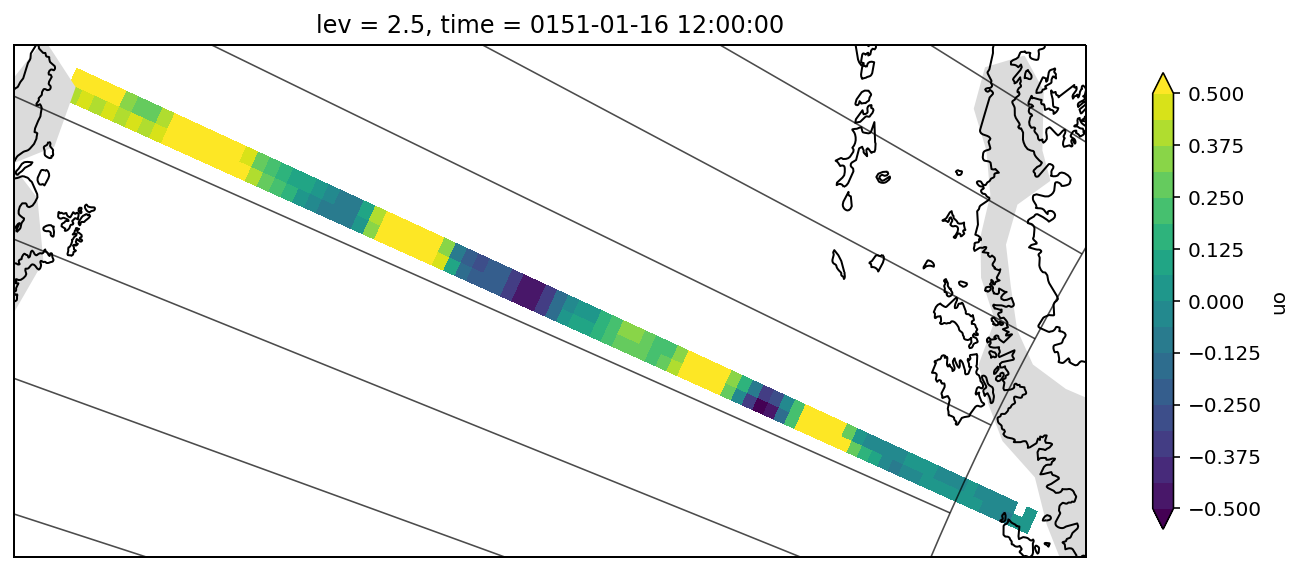

In [40]:
uo = ds.uo.isel(time=[0],lev=[0],x=slice(935,937),y=slice(151,238))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=-90.0))

ax.coastlines(resolution='10m',zorder=3) # zorder=3 makes sure that no other plots overlay the coastlines
gl = ax.gridlines(color='black', alpha=0.7)
gl.ylocator = mticker.FixedLocator([-65, -45, 0])
ax.add_feature(cartopy.feature.LAND, zorder=1,facecolor=cartopy.feature.COLORS['land_alt1'])
uo.plot(ax = ax, transform=ccrs.PlateCarree(),
               vmin = -0.5 , vmax=0.5 , levels=17 ,
               cbar_kwargs={'shrink': 0.7})

In [63]:
uo = ds.uo.isel(x=slice(935,936),y=slice(151,238))
print(len(uo[0,:,0,0]))
print(uo[0,:,0,0])
depths=[]
#27 ; 35
#for i in range(len(ds.uo.lev)):
for i in range(27):
    if i ==0:
        #print('ololo')
        #depths.append(2.5)
        uo.isel(lev=[i])*2.5*111/4
    else:
        print(i)
        #depths.append(ds.lev[i]-ds.lev[i-1])
        uo.isel(lev=[i])*(ds.lev[i]-ds.lev[i-1])*111/4
print(uo)

ACC_surf = uo.sum(dim='y',skipna=True).sum(dim='lev',skipna=True)
#ACC.plot.line()

35
<xarray.DataArray 'uo' (lev: 35)>
dask.array<getitem, shape=(35,), dtype=float32, chunksize=(35,), chunktype=numpy.ndarray>
Coordinates:
    lat      float32 dask.array<chunksize=(), meta=np.ndarray>
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    lon      float32 dask.array<chunksize=(), meta=np.ndarray>
    time     object 0151-01-16 12:00:00
    x        float64 -65.6
    y        float64 -65.7
Attributes:
    cell_methods:   time: mean
    interp_method:  none
    long_name:      Sea Water X Velocity
    original_name:  uo
    standard_name:  sea_water_x_velocity
    units:          m s-1
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
<xarray.DataArray 'uo' (time: 6000, lev: 35, y: 87, x: 1)>
dask.array<getitem, shape=(6000, 35, 87, 1), dtype=float32, chunksize=(1, 35, 87, 1), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(87, 1), meta=np.ndarray>
  * lev      (lev) float64 2.5 10.0 

In [64]:
uo = ds.uo.isel(x=slice(935,936),y=slice(151,238))
print(len(uo[0,:,0,0]))
print(uo[0,:,0,0])
depths=[]
#27 ; 35
#for i in range(len(ds.uo.lev)):
for i in range(27,35):
    if i ==0:
        #print('ololo')
        #depths.append(2.5)
        uo.isel(lev=[i])*2.5*111/4
    else:
        print(i)
        #depths.append(ds.lev[i]-ds.lev[i-1])
        uo.isel(lev=[i])*(ds.lev[i]-ds.lev[i-1])*111/4
print(uo)

ACC_deep = uo.sum(dim='y',skipna=True).sum(dim='lev',skipna=True)

35
<xarray.DataArray 'uo' (lev: 35)>
dask.array<getitem, shape=(35,), dtype=float32, chunksize=(35,), chunktype=numpy.ndarray>
Coordinates:
    lat      float32 dask.array<chunksize=(), meta=np.ndarray>
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    lon      float32 dask.array<chunksize=(), meta=np.ndarray>
    time     object 0151-01-16 12:00:00
    x        float64 -65.6
    y        float64 -65.7
Attributes:
    cell_methods:   time: mean
    interp_method:  none
    long_name:      Sea Water X Velocity
    original_name:  uo
    standard_name:  sea_water_x_velocity
    units:          m s-1
27
28
29
30
31
32
33
34
<xarray.DataArray 'uo' (time: 6000, lev: 35, y: 87, x: 1)>
dask.array<getitem, shape=(6000, 35, 87, 1), dtype=float32, chunksize=(1, 35, 87, 1), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(87, 1), meta=np.ndarray>
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
   

In [65]:
ACC_surf

<xarray.DataArray 'uo' (time: 6000, x: 1)>
dask.array<sum-aggregate, shape=(6000, 1), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0151-01-16 12:00:00 ... 0650-12-16 12:00:00
  * x        (x) float64 -65.6

In [67]:
#print(len(test)/60)
data_surf=[]
data_deep=[]
for i in range(len(ACC_surf)):
    tt=np.asarray(ACC_surf[i])
    data_surf.append(tt)
    tt=np.asarray(ACC_deep[i])
    data_deep.append(tt)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
27

KeyboardInterrupt: 

In [18]:
uo = ds.uo.isel(time=[0],lev=[0],x=slice(935,936),y=slice(151,238))
uo

<xarray.DataArray 'uo' (time: 1, lev: 1, y: 87, x: 1)>
dask.array<getitem, shape=(1, 1, 87, 1), dtype=float32, chunksize=(1, 1, 87, 1), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(87, 1), meta=np.ndarray>
  * lev      (lev) float64 2.5
    lon      (y, x) float32 dask.array<chunksize=(87, 1), meta=np.ndarray>
  * time     (time) object 0151-01-16 12:00:00
  * x        (x) float64 -65.6
  * y        (y) float64 -65.7 -65.6 -65.5 -65.39 ... -55.49 -55.35 -55.21
Attributes:
    cell_methods:   time: mean
    interp_method:  none
    long_name:      Sea Water X Velocity
    original_name:  uo
    standard_name:  sea_water_x_velocity
    units:          m s-1